<a href="https://colab.research.google.com/github/rlcoelho/mvp-qualidade/blob/master/MVP3_MeuColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Sprint: Qualidade de Software, Segurança e Sistemas Inteligentes
### Prática de Machine Learning em Python - Rodrigo Lemos Coelho
##### Problema. Saber se o aluno irá concluir o curso online, baseado no seu comportamento ao longo do curso

## Imports para criação e treinamento do modelo

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from pickle import dump
from google.colab import files

## Carga do Dataset

In [ ]:
# Dataset Predict Online Course Engagement
# Entendendo a relação entre o comportamento do usuário e a conclusão do curso
# Rabie El Kharoua. (2024). 🎓 Predict Online Course Engagement Dataset [Data set]. Kaggle.
# DOI 10.34740/kaggle/dsv/8725325

# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/rlcoelho/mvp-qualidade/main/online_course_engagement_data.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,UserID,CourseCategory,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion
0,5618,Health,29.979719,17,3,50.365656,20.860773,1,0
1,4326,Arts,27.802640,1,5,62.615970,65.632415,1,0
2,5849,Arts,86.820485,14,2,78.458962,63.812007,1,1
3,4992,Science,35.038427,17,10,59.198853,95.433162,0,1
4,3866,Programming,92.490647,16,0,98.428285,18.102478,0,0


## Exploração dos dados

In [ ]:
def get_df_info(dataset):
    print("\n\033[1mFormato do DataFrame:\033[0m ", dataset.shape)
    print("\n\033[1mColunas no DataFrame:\033[0m ", dataset.columns.to_list())
    print("\n\033[1mTipos de dados das colunas:\033[0m\n", dataset.dtypes)

    print("\n\033[1mInformações sobre o DataFrame:\033[0m")
    dataset.info()

    print("\n\033[1mNúmero de valores exclusivos em cada coluna:\033[0m")
    for col in dataset.columns:
        print(f"\033[1m{col}\033[0m: {dataset[col].nunique()}")

    print("\n\033[1mNúmero de valores nulos em cada coluna:\033[0m\n", dataset.isnull().sum())
    print("\n\033[1mNúmero de linhas duplicadas:\033[0m ", dataset.duplicated().sum())
    print("\n\033[1mEstatísticas do DataFrame:\033[0m\n", dataset.describe().transpose())

# Chamada da função
get_df_info(dataset)


Formato do DataFrame:  (9000, 9)

Colunas no DataFrame:  ['UserID', 'CourseCategory', 'TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 'QuizScores', 'CompletionRate', 'DeviceType', 'CourseCompletion']

Tipos de dados das colunas:
 UserID                     int64
CourseCategory            object
TimeSpentOnCourse        float64
NumberOfVideosWatched      int64
NumberOfQuizzesTaken       int64
QuizScores               float64
CompletionRate           float64
DeviceType                 int64
CourseCompletion           int64
dtype: object

Informações sobre o DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UserID                 9000 non-null   int64  
 1   CourseCategory         9000 non-null   object 
 2   TimeSpentOnCourse      9000 non-null   float64
 3   NumberOfVideosWatched  9000 non-n

## Pré Processamento e separação em conjunto de treino e conjunto de teste com holdout

In [ ]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 202409 # semente aleatória

# Drop da coluna 'UserID'
df = dataset.drop('UserID', axis = 1)

# Divide o DataFrame em (X) e (y)
X = df.drop('CourseCompletion', axis=1)
y = df['CourseCompletion']

# Converte a coluna 'CourseCategory' em novas colunas para representá-las
X = pd.get_dummies(X)

# Separação em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.850278 (0.016768)
CART: 0.926944 (0.013150)
NB: 0.825694 (0.010745)
SVM: 0.831389 (0.017504)


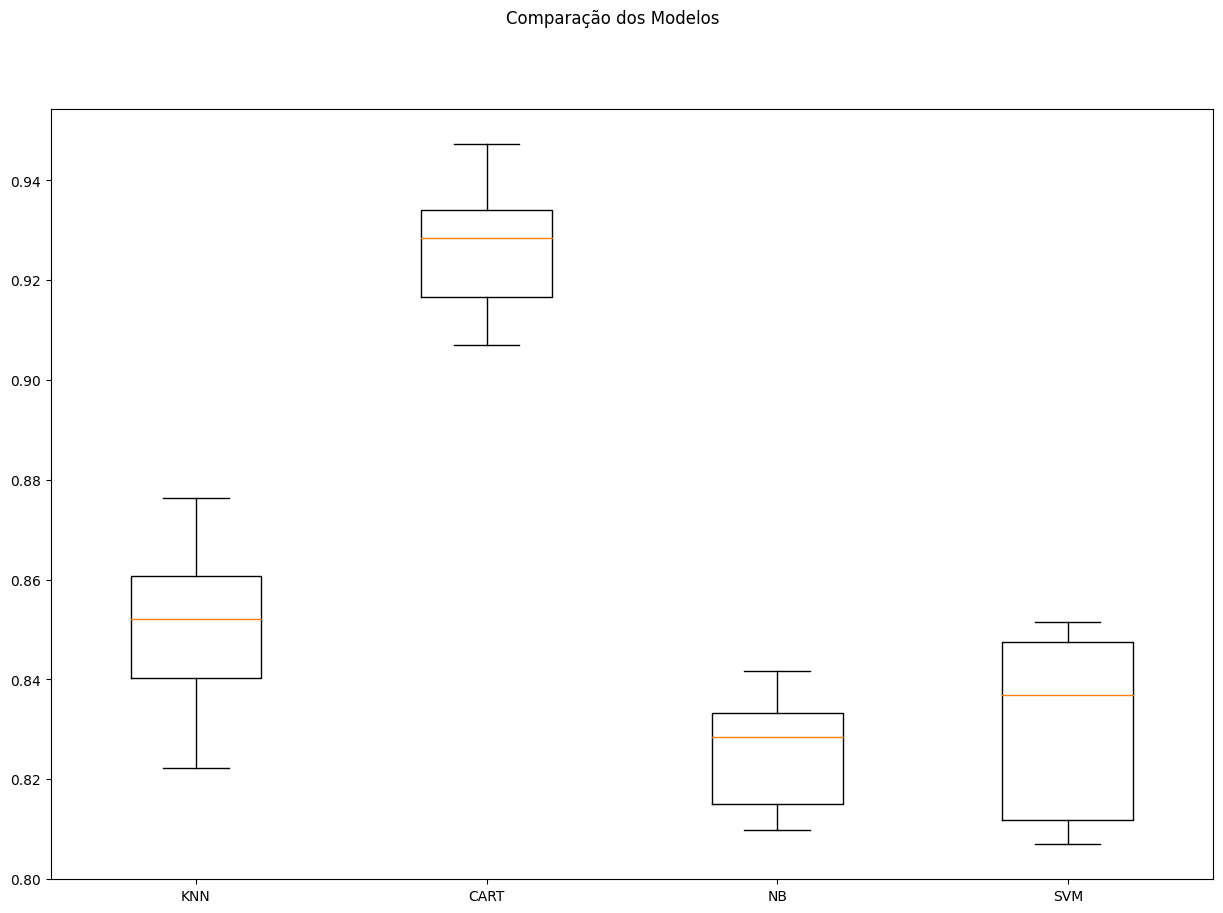

In [ ]:
np.random.seed(202409) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.850 (0.017)
CART-orig: 0.927 (0.013)
NB-orig: 0.826 (0.011)
SVM-orig: 0.831 (0.018)
KNN-padr: 0.845 (0.014)
CART-padr: 0.927 (0.011)
NB-padr: 0.826 (0.011)
SVM-padr: 0.859 (0.009)
KNN-norm: 0.847 (0.013)
CART-norm: 0.926 (0.013)
NB-norm: 0.826 (0.011)
SVM-norm: 0.849 (0.012)


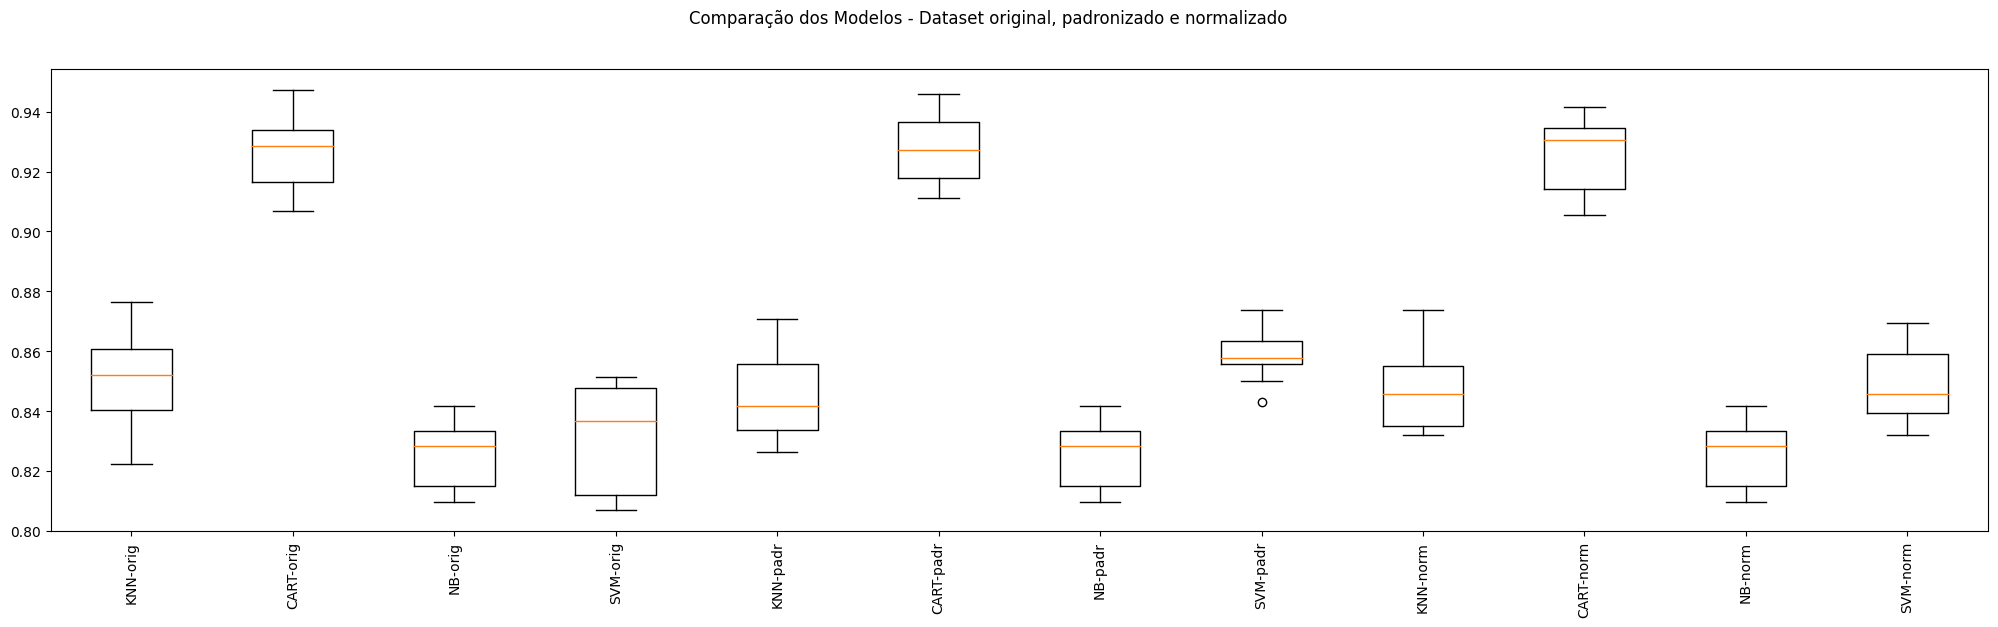

In [ ]:
np.random.seed(202409) # definindo uma semente global para este bloco

# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização com hiperparâmetros

#### Otimização do KNN

In [ ]:
# Tuning do KNN
# Utilizando hiperparâmetros: n_neighbors e metric
# Tempo de execução: 1m34s

# O melhor resultado foi inferior a CART-padr: 0.927 (0.011)

np.random.seed(202409) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Resultado: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Resultado: knn-orig - Melhor: 0.869722 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 17}
Resultado: knn-padr - Melhor: 0.869722 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 15}
Resultado: knn-norm - Melhor: 0.869306 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 15}


#### Otimização do SVM

In [ ]:
# Tuning do SVM
# Utilizando hiperparâmetros: C (Regularização) e Gamma
# Tempo de execução: 16m31s

# O melhor resultado foi inferior a CART-padr: 0.927 (0.011)

np.random.seed(202409) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('svm-orig', Pipeline(steps=[svm])))
pipelines.append(('svm-padr', Pipeline(steps=[standard_scaler, svm])))
pipelines.append(('svm-norm', Pipeline(steps=[min_max_scaler, svm])))

param_grid = {
    'SVM__C': [0.1, 1, 10, 100],
    'SVM__gamma': [1, 0.1, 0.01, 0.001]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Resultado: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Resultado: svm-orig - Melhor: 0.898611 usando {'SVM__C': 100, 'SVM__gamma': 0.001}
Resultado: svm-padr - Melhor: 0.885139 usando {'SVM__C': 100, 'SVM__gamma': 0.1}
Resultado: svm-norm - Melhor: 0.875278 usando {'SVM__C': 100, 'SVM__gamma': 1}


#### Otimização do Naive Bayes

In [ ]:
# Tuning do Gaussian Naive Bayes
# Utilizando hiperparâmetro: var_smoothing
# Tempo de execução: 2s

# O melhor resultado foi inferior a CART-padr: 0.927 (0.011)

np.random.seed(202409) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
nb = ('NB', GaussianNB())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('nb-orig', Pipeline(steps=[nb])))
pipelines.append(('nb-padr', Pipeline(steps=[standard_scaler, nb])))
pipelines.append(('nb-norm', Pipeline(steps=[min_max_scaler, nb])))

param_grid = {
    'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Resultado: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Resultado: nb-orig - Melhor: 0.826528 usando {'NB__var_smoothing': 1e-05}
Resultado: nb-padr - Melhor: 0.825694 usando {'NB__var_smoothing': 1e-09}
Resultado: nb-norm - Melhor: 0.825694 usando {'NB__var_smoothing': 1e-09}


#### Otimização da Árvore de Decisão

In [ ]:
# Tuning da Árvore de Decisão
# Utilizando hiperparâmetros: criterion, max_depth, min_samples_split, min_samples_leaf, max_features
# Tempo de execução: 5m52s

# O melhor resultado foi superior a CART-padr: 0.927 (0.011)
# Melhor escolha: cart-norm - Melhor: 0.951806 usando
#    {'CART__criterion': 'gini', 'CART__max_depth': 10, 'CART__max_features': None,
#    'CART__min_samples_leaf': 2, 'CART__min_samples_split': 10}

np.random.seed(202409) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
cart = ('CART', DecisionTreeClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('cart-orig', Pipeline(steps=[cart])))
pipelines.append(('cart-padr', Pipeline(steps=[standard_scaler, cart])))
pipelines.append(('cart-norm', Pipeline(steps=[min_max_scaler, cart])))

param_grid = {
    'CART__criterion': ['gini', 'entropy'],
    'CART__max_depth': [None, 10, 20, 30, 40, 50],
    'CART__min_samples_split': [2, 5, 10],
    'CART__min_samples_leaf': [1, 2, 4],
    'CART__max_features': [None, 'sqrt', 'log2']
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Resultado: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Resultado: cart-orig - Melhor: 0.951250 usando {'CART__criterion': 'gini', 'CART__max_depth': 10, 'CART__max_features': None, 'CART__min_samples_leaf': 2, 'CART__min_samples_split': 10}
Resultado: cart-padr - Melhor: 0.950694 usando {'CART__criterion': 'gini', 'CART__max_depth': 10, 'CART__max_features': None, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Resultado: cart-norm - Melhor: 0.951806 usando {'CART__criterion': 'gini', 'CART__max_depth': 10, 'CART__max_features': None, 'CART__min_samples_leaf': 2, 'CART__min_samples_split': 10}


## Finalização do Modelo

In [ ]:
# Avaliação do modelo com o conjunto de testes

# Melhor escolha: cart-norm - Melhor: 0.951806 usando
#    {'CART__criterion': 'gini', 'CART__max_depth': 10, 'CART__max_features': None,
#    'CART__min_samples_leaf': 2, 'CART__min_samples_split': 10}
# Scaler para cart-norm = MinMaxScaler()

# Preparação do modelo
scaler = MinMaxScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino

cart = ('CART', DecisionTreeClassifier())
model = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=10)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.9472222222222222


In [ ]:
# Preparação do modelo com TODO o dataset
scaler = MinMaxScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação do scaler com TODO o dataset
model.fit(rescaledX, y)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10)

### Salvando o arquivo pkl como um Pipeline contendo o modelo e o scaler

In [ ]:
# Cria o pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('classifier', model)
])

# Salva o pipeline no arquivo pkl
filename = 'pipeline-online-course-cart-norm.pkl'
dump(pipeline, open(filename, 'wb'))

# Baixa o arquivo pkl
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Simulando a aplicação do modelo em dados não vistos

In [ ]:
print("\n\033[1mInformações sobre o DataFrame:\033[0m")
X.info()


Informações sobre o DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   TimeSpentOnCourse           9000 non-null   float64
 1   NumberOfVideosWatched       9000 non-null   int64  
 2   NumberOfQuizzesTaken        9000 non-null   int64  
 3   QuizScores                  9000 non-null   float64
 4   CompletionRate              9000 non-null   float64
 5   DeviceType                  9000 non-null   int64  
 6   CourseCategory_Arts         9000 non-null   bool   
 7   CourseCategory_Business     9000 non-null   bool   
 8   CourseCategory_Health       9000 non-null   bool   
 9   CourseCategory_Programming  9000 non-null   bool   
 10  CourseCategory_Science      9000 non-null   bool   
dtypes: bool(5), float64(3), int64(3)
memory usage: 465.9 KB


In [ ]:
# Novos dados - não sabemos a classe!
data = {'timesp': [54.58, 64.55, 36.96],
        'nvideo': [10, 28, 39],
        'nquizz': [29, 10, 110],
        'qscore': [50.36, 60, 18.99],
        'corate': [20.86, 30, 80.16],
        'device': [1, 0, 1],
        'coarts': [0, 0, 0],
        'cobusi': [1, 0, 0],
        'coheal': [0, 1, 0],
        'coprog': [0, 0, 1],
        'coscie': [0, 0, 0],
        }

atributos = ['timesp', 'nvideo', 'nquizz', 'qscore', 'corate', 'device', 'coarts', 'cobusi', 'coheal', 'coprog', 'coscie']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:11].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[ 5.41228572e-01  5.00000000e-01  2.90000000e+00  7.09906637e-03
   2.08568501e-01  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.41948534e-01  1.40000000e+00  1.00000000e+00  1.99938153e-01
   2.99995577e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.63225989e-01  1.95000000e+00  1.10000000e+01 -6.20428126e-01
   8.01744173e-01  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00]]


In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0 0 1]
